In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime
from pandas_ods_reader import read_ods

In [2]:
data = read_ods('dataset/btc.ods',1)
data.head()


,Date,Close,Open,High,Low,Volume,변동 %
0,2021년 03월 01일,45832.6,45160.5,46809.5,45008.8,116.91K,1.48%
1,2021년 02월 28일,45164.0,46136.0,46582.0,43100.6,135.08K,-2.11%
2,2021년 02월 27일,46136.7,46333.1,48335.1,45059.4,98.75K,-0.45%
3,2021년 02월 26일,46345.6,46928.5,48413.9,44248.2,189.41K,-1.24%
4,2021년 02월 25일,46928.5,49695.9,52013.8,46773.7,83.22K,-5.57%


In [3]:
btc_data = data[data['Date'] >= '2015년 01월 01일']
btc_data.drop(['변동 %'], axis=1)

,Date,Close,Open,High,Low,Volume
0,2021년 03월 01일,45832.6,45160.5,46809.5,45008.8,116.91K
1,2021년 02월 28일,45164.0,46136.0,46582.0,43100.6,135.08K
2,2021년 02월 27일,46136.7,46333.1,48335.1,45059.4,98.75K
3,2021년 02월 26일,46345.6,46928.5,48413.9,44248.2,189.41K
4,2021년 02월 25일,46928.5,49695.9,52013.8,46773.7,83.22K
...,...,...,...,...,...,...
2247,2015년 01월 05일,274.8,264.7,278.3,262.9,54.99K
2248,2015년 01월 04일,264.7,287.1,289.9,255.9,88.77K
2249,2015년 01월 03일,287.1,315.2,315.8,284.9,47.37K
2250,2015년 01월 02일,315.2,314.9,316.4,313.1,14.73K


In [4]:
btc_data["Volume"] = btc_data["Volume"].apply(lambda x: float(x[:-1])*1000 if str(x).endswith('K') else float(x[:-1])*1000000 if str(x).endswith('M') else x)

<ipython-input-4-823f990de01e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_data["Volume"] = btc_data["Volume"].apply(lambda x: float(x[:-1])*1000 if str(x).endswith('K') else float(x[:-1])*1000000 if str(x).endswith('M') else x)


In [5]:
btc_data

,Date,Close,Open,High,Low,Volume,변동 %
0,2021년 03월 01일,45832.6,45160.5,46809.5,45008.8,116910.0,1.48%
1,2021년 02월 28일,45164.0,46136.0,46582.0,43100.6,135080.0,-2.11%
2,2021년 02월 27일,46136.7,46333.1,48335.1,45059.4,98750.0,-0.45%
3,2021년 02월 26일,46345.6,46928.5,48413.9,44248.2,189410.0,-1.24%
4,2021년 02월 25일,46928.5,49695.9,52013.8,46773.7,83220.0,-5.57%
...,...,...,...,...,...,...,...
2247,2015년 01월 05일,274.8,264.7,278.3,262.9,54990.0,3.82%
2248,2015년 01월 04일,264.7,287.1,289.9,255.9,88770.0,-7.80%
2249,2015년 01월 03일,287.1,315.2,315.8,284.9,47370.0,-8.91%
2250,2015년 01월 02일,315.2,314.9,316.4,313.1,14730.0,0.10%


In [6]:

open_prices = btc_data['Open'].values
high_prices = btc_data['High'].values
low_prices = btc_data['Low'].values
close_prices = btc_data['Close'].values
volumes = btc_data['Volume'].values
mid_prices = (high_prices + low_prices) / 2

In [7]:
seq_len = 60
sequence_length = seq_len + 1

open_prices_w = []
mid_prices_w = []
high_prices_w= []
low_prices_w = []
close_prices_w = []
volumes_w = []
for index in range(len(open_prices) - sequence_length):
    open_prices_w.append(open_prices[index: index + sequence_length])
    mid_prices_w.append(mid_prices[index: index+sequence_length])
    high_prices_w.append(high_prices[index:index+sequence_length])
    low_prices_w.append(low_prices[index:index+sequence_length])
    close_prices_w.append(close_prices[index:index+sequence_length])
    volumes_w.append(volumes[index:index+sequence_length])

#

In [8]:
def normalize_windows(data):
    normalized_data = []
    for window in data:
        normalized_window = [((float(str(p).replace(',','')) / float(str(window[0]).replace(',',''))) - 1) for p in window]
        normalized_data.append(normalized_window)
    return np.array(normalized_data)

open_prices_w_normal = normalize_windows(open_prices_w)
mid_prices_w_normal = normalize_windows(mid_prices_w)
high_prices_w_normal = normalize_windows(high_prices_w)
low_prices_w_normal = normalize_windows(low_prices_w)
close_prices_w_normal = normalize_windows(close_prices_w)
volumes_w_normal = normalize_windows(volumes_w)

In [9]:
print(open_prices_w_normal[0])

[ 0.          0.02160074  0.02596517  0.03914926  0.10042847  0.08305045
  0.19826176  0.27185483  0.23797566  0.23829453  0.14237221  0.15354126
  0.08859069  0.06141872  0.07640748  0.04454335  0.04899414  0.06276503
 -0.00721205  0.02983359  0.02736684 -0.13965523 -0.13134487 -0.15190044
 -0.18122253 -0.1663312  -0.21420489 -0.2578913  -0.26690803 -0.24089414
 -0.24048671 -0.26082085 -0.32664829 -0.28035341 -0.28601101 -0.28600658
 -0.28945649 -0.26940357 -0.31713112 -0.21452818 -0.20589675 -0.18887966
 -0.20642597 -0.20239811 -0.1861959  -0.13252289 -0.17221023 -0.24577452
 -0.21555342 -0.15423213 -0.11095537 -0.10082484 -0.12608585 -0.18516181
 -0.24714518 -0.29107517 -0.26890535 -0.28714474 -0.34988098 -0.35891542
 -0.36079539]


In [10]:
print(mid_prices_w_normal[0])

[ 0.         -0.02326007  0.01716651  0.00918989  0.07590208  0.07106644
  0.08049049  0.15265258  0.23981603  0.21596566  0.16594731  0.12685162
  0.10648749  0.06253546  0.03163095  0.05367884  0.0277668   0.03624223
  0.00920187 -0.0078688   0.01557315 -0.07803346 -0.1605889  -0.13726349
 -0.18378362 -0.18220333 -0.20442548 -0.24374008 -0.27018361 -0.27532747
 -0.26126491 -0.23218683 -0.30620911 -0.32654166 -0.30550119 -0.27223985
 -0.30277842 -0.29360923 -0.31721236 -0.28453369 -0.23948821 -0.1959947
 -0.2132527  -0.23016654 -0.20124746 -0.19184193 -0.16327791 -0.23526683
 -0.24664909 -0.25255859 -0.16678919 -0.12720449 -0.14466833 -0.16463167
 -0.23388802 -0.29834031 -0.32701869 -0.2726341  -0.32212315 -0.36462012
 -0.37568219]


In [11]:
# split train and test data
# row 인덱스를 구한다.
row_idx = int(round(open_prices_w_normal.shape[0] * 0.9))
#row_idx = int(round(result.shape[0] * 0.9))
# 0~row_idx 까지의 데이터를 추출한다.
train = np.dstack(
    (open_prices_w_normal[:row_idx, :],
     mid_prices_w_normal[:row_idx,:],
     high_prices_w_normal[:row_idx,:],
     low_prices_w_normal[:row_idx,:],
     close_prices_w_normal[:row_idx,:],
     volumes_w_normal[:row_idx,:],)
)

test = np.dstack(
    (open_prices_w_normal[row_idx:, :],
     mid_prices_w_normal[row_idx:,:],
     high_prices_w_normal[row_idx:,:],
     low_prices_w_normal[row_idx:, :],
     close_prices_w_normal[row_idx:, :],
     volumes_w_normal[row_idx:, :],
     )
)

# 값을 섞는다.
#np.random.shuffle(train)



In [12]:
# train에서 마지막 결과값을 제외하고, 50개를 x_train에 담는다.
x_train = train[:,:-1, :]
# x_train의 차원을 x, y => x, y, 1 로 변경한다. 이유는 아직 모름
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# train의 51번째 데이터를 예상 결과 값으로 저장한다.
y_train = train[:,-1, :]

x_test = test[:, :-1, :]
#x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = test[:, -1,:]

open_prices_w_normal.shape,x_train.shape, x_test.shape

((2191, 61), (1972, 60, 6), (219, 60, 6))

In [13]:
#x_train

In [14]:
model = Sequential()

model.add(LSTM(128, return_sequences=True, input_shape=(seq_len, 6)))
#model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=False))

# softmax, elu, selu, softplus, softsign, relu, tanh, sigmoid, hard_sigmoid, exponential, linear
model.add(Dense(1, activation='linear'))
# rmsprop, sgd, Adgrad, Adadelta, Adam, Adamax, Nadam
model.compile(loss='mse', optimizer='rmsprop')


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 128)           69120     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 89,761
Trainable params: 89,761
Non-trainable params: 0
_________________________________________________________________


In [15]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20,
    callbacks=[
        TensorBoard(log_dir='logs/%s' % (start_time)),
        ModelCheckpoint('./models/%s_eth.h5' % (start_time), monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')
])

Epoch 1/20
198/198 [==============================] - 7s 28ms/step - loss: 19.3711 - val_loss: 0.1519

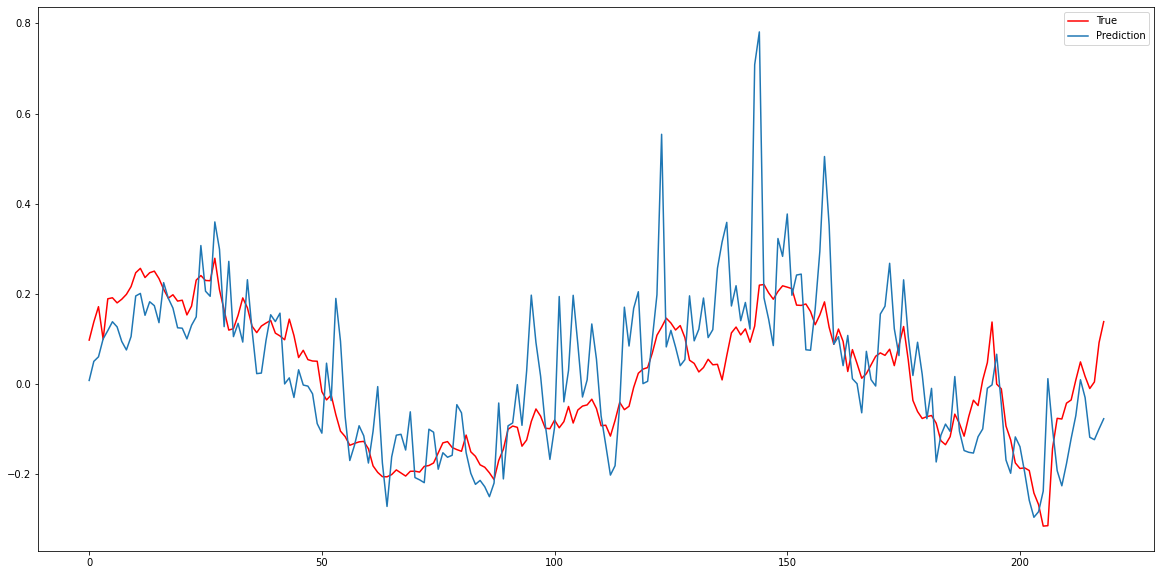

In [16]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test[:,1], label='True',color='red')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

In [17]:
print(y_test)

[[ 0.12921577  0.09695234  0.12778002  0.06539735  0.06419753  0.31853035]
 [ 0.1578509   0.13737166  0.12924071  0.14578112  0.12921577 -0.45700152]
 [ 0.18212337  0.17110505  0.17255717  0.16962775  0.1578509  -0.45689092]
 ...
 [ 0.05590291  0.00404709  0.03240741 -0.02625571 -0.03815407 -0.28202847]
 [ 0.1233072   0.09138808  0.11001757  0.07145543  0.05590291 -0.65920863]
 [ 0.15010957  0.1379248   0.10205503  0.17662533  0.1233072  -0.91062978]]
